# Inventory Optimization and Demand Forecasting

#### Optimize inventory management by identifying the product categories (clustering as an outcome of text processing) on the customer review data. Predict what kind of products could be in demand (Time Series Analysis).

## LIBRARIES

#### Data wraggling

In [1]:
pip install polars

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nlppreprocess

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pipe

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import polars
import re
import spacy
from nlppreprocess import NLP
nlp = spacy.load('en_core_web_sm')
import mysql.connector as sql
from sqlalchemy import create_engine
db=sql.connect(user='root',host='localhost',password='1234',database='capstone')
mycursor=db.cursor()
engine=create_engine(f"mysql+pymysql://{'root'}:{'1234'}@{'localhost'}/{'capstone'}")

#### Data visualization

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import rcParams
rcParams['figure.figsize']=(12,7)

#### Machine Learning

In [6]:
import mysql.connector as sql
import pandas as pd
from textblob import TextBlob
from afinn import Afinn
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### NLP

In [7]:
from textblob import TextBlob
from afinn import Afinn

#### Time Series

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa import statespace
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import product
from tqdm import tqdm_notebook

## USER DEFINE FUNCTION

#### Cleaning

In [9]:
def clean(text):
    text=re.sub(r'https?://\S+|www\.\S+','',str(text))
    text=re.sub(r'<.*?>','',text)
    text=re.sub('\n', ' ', text)
    text=re.sub('\\n', ' ', text)
    text=re.sub('\t', ' ', text)
    #text=re.sub(r'[a-bA-b]+\d+\w+', ' ', text)
    text=re.sub(r'\\n(\\t)+<\w+\s\S+\s\S+', '', text)
    text=re.sub(r'\s+', ' ', text)
    return text

#### Lemmatization

In [10]:
def lem(text):
    R1_doc=nlp(text)
    return " ".join(token.lemma_ for token in R1_doc)

#### Stopwords

In [11]:
nlpp=NLP(remove_stopwords= True,
    replace_words = True,
    remove_numbers = True,
    remove_html_tags = True,
    remove_punctuations = True)

#### Textblob

In [12]:
def analyze_sentiment(review):
    testimonial = TextBlob(review)
    polarity = testimonial.sentiment.polarity
    subjectivity = testimonial.sentiment.subjectivity

    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    elif polarity >= -0.1 and polarity <= 0.1:
        if subjectivity >= 0.5:
            return 'conflicted'
        else:
            return 'neutral'

#### Afinn

In [13]:
afinn = Afinn()

# Classify the sentiment of each text as positive, negative, neutral, or mixed
def get_sentiment_category(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    elif score==0:
        return 'Neutral'

#### Checking stationarity(TSA)

In [14]:
def checkstat(data):
    movingAverage = data.rolling(window=12).mean()
    movingSTD = data.rolling(window=12).std()
    #Plot rolling statistics: 
    orig =plt.plot(data, color='blue',label='Original') 
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean') 
    std =plt.plot(movingSTD, color='black', label = 'Rolling Std')
    plt. legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    pvalue=adfuller(data)[1]
    if pvalue<.05:
        msg =  "pvalue={}. Data is Stationary. Proceed to model building".format(pvalue)
    else:
        msg = "pvalue={}. Data is not Stationary. Make the data stationary before model building".format(pvalue)
    return msg

#### performance check

In [15]:
def LJUNGBOX(mod):
    pvalue = acorr_ljungbox(mod.resid,lags=[1],return_df=True)['lb_pvalue'].values
    print(pvalue)
    
    if(pvalue<0.05):
        print('Reject H0 , Bad model')
    else:
        print('Failure to reject H0,Good model')

#### Forcasting and predicting

In [81]:
def forecasting(data,p,d,q,P,D,Q,start,end):
    model_fit = SARIMAX(data,order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
    # fig,ax=plt.subplots(1,2,figsize=(22,7))
    # pd.concat([data.polarity,model_fit.predict(start=start,end=end)]).plot(ax=ax[0],label='Actual')
    # model_fit.predict(start=start,end=end).plot(ax=ax[0],label='prediction')
    # ax[0].legend()
    plt.figure(figsize=(22,7),dpi=100)
    print(model_fit.aic)
    pd.concat([data.polarity,model_fit.forecast(15)],axis=0).plot(label='Observed')
    model_fit.forecast(15).plot(label='forecasted')
    plt.legend()
    print(model_fit.aic)
    return LJUNGBOX(model_fit)

In [17]:
def errorcheck(pred):    
    actual = []; p = []
    for i in range(len(pred)):
        actual.append(test.Sales[i])
        p.append(pred[i])
    df = pd.DataFrame({'actual':actual,'predicted':p})
    df['error'] = df.actual-df.predicted
    mse = mean_squared_error(df.actual,df.predicted)
    rmse = mean_squared_error(df.actual,df.predicted,squared=False)
    
    
    fig,ax = plt.subplots(1,2,figsize=(15,6))
    #plotting
    ax[0].plot(df.error)
    ax[0].set_title('Error plot')
    
    #plotting actual & predicted
    ax[1].plot(df.actual)
    ax[1].plot(df.predicted)
    ax[1].set_title('ACTUAL vs PREDiCTED')
    plt.show()
    
    return df,mse,rmse

#### Hypertuning SARIMA(TSA)

In [18]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

# Preprocessing

### Video Games

In [19]:
vg_m=polars.read_ndjson('meta_Video_Games.json').to_pandas()
vg_r=polars.read_ndjson('Video_Games.json').to_pandas()

In [20]:
vg_m.drop(['tech1','fit','tech2','similar_item','imageURL','date','price','imageURLHighRes','also_view','also_buy','description','feature','rank'],axis=1,inplace=True)
vg_r.drop(['vote','summary','verified','unixReviewTime'],axis=1,inplace=True)

In [21]:
vg_r.drop(vg_r[vg_r.reviewerName.isna()].index,axis=0,inplace=True)
vg_r.drop(vg_r[vg_r.reviewText.isna()].index,axis=0,inplace=True)

In [22]:
vg=vg_r.merge(vg_m,on='asin')

In [23]:
vg.drop(vg[vg['category'].str.len()== 0].index,axis=0,inplace=True)
vg.drop(vg[vg['reviewText']== ''].index,axis=0,inplace=True)
vg.drop(vg[vg['title']== ''].index,axis=0,inplace=True)
vg.drop(vg[vg['brand']== ''].index,axis=0,inplace=True)
vg.drop(vg[vg['main_cat']== ''].index,axis=0,inplace=True)
vg.drop(vg[vg['reviewerName']== ''].index,axis=0,inplace=True)

In [27]:
vg.drop_duplicates(subset=['asin','reviewerID'],inplace=True)

In [28]:
vg['reviewTime']=pd.to_datetime(vg.reviewTime,infer_datetime_format=True)

In [29]:
vg.sort_values('reviewTime',ignore_index=True,inplace=True)

In [30]:
#vg[(vg.reviewTime>'2016-10-02') & (vg.reviewTime < '2017-7') ]

,overall,reviewTime,reviewerID,asin,reviewerName,reviewText,category,title,brand,main_cat
1947662,5.0,2016-10-03,A1K33HYDFCZFR3,B000CSUKZ0,MT,Mint condition! Excellent!,"[Video Games, Retro Gaming & Microconsoles, Pl...",Driver Parallel Lines - PlayStation 2,by\n \n Atari,Video Games
1947663,5.0,2016-10-03,A1Z0WCABRDMJ8A,B00004U8QX,Alpha13,Thank you,"[Video Games, Retro Gaming & Microconsoles, Pl...",Trenro AV to RCA Cable Compatible with Playsta...,Trenro,Computers
1947664,5.0,2016-10-03,A1BCJMBXBLD1D3,B01AC3ZDB0,Kimbery O.,Daughter loves it,"[Video Games, Kids & Family, Wii, Games, </spa...",Nintendo Selects: Animal Crossing: City Folk,by\n \n Nintendo,Video Games
1947665,1.0,2016-10-03,A17LEKGJG7V1WB,B019MFPLC0,KMac,I hate to knock the product as the stick and b...,"[Video Games, PlayStation 3, Accessories, Cont...",Mayflash F300 Arcade Fight Stick Joystick for ...,May Flash,Computers
1947666,5.0,2016-10-03,A26DK3BH8YPM4P,B00HQY9FIG,Lepacol,Really cute case to protect my nintendo.,"[Video Games, Nintendo DS, Accessories, </span...",Official Nintendo Mario Travel Case for Ninten...,by\n \n PowerA,Video Games
...,...,...,...,...,...,...,...,...,...,...
2217037,3.0,2017-06-30,A15HRKPETHMJJX,B002M2N9NO,Amazon Customer,"Game played great, but the case arrived broken...","[Video Games, Retro Gaming & Microconsoles, Pl...",Rock Band,by\n \n MTV Games,Video Games
2217038,5.0,2017-06-30,A3KNQR3EAFGCXK,B016Y3CTJQ,Amazon Customer,"Perfect, just what the Boy wanted","[Video Games, PlayStation 4, Accessories, Batt...","PS4 Controller Charger, Megadream Playstation ...",Megadream,All Electronics
2217039,3.0,2017-06-30,A25X9AIOTYUFQ2,B017XP8NEE,Aryn,Great for casual gaming. Not so great for comp...,"[Video Games, Retro Gaming & Microconsoles, Ga...",Replacement 3D Analog Joystick for NGC GameCub...,Vivi Audio,Computers
2217040,1.0,2017-06-30,A30E9DIIH3EX6B,B00LCHZRIK,Amazon Customer,This was a gift I bought and sent to Bulgaria ...,"[Video Games, Wii U, Games, </span></span></sp...",The Legend of Zelda: Breath of the Wild - Wii U,by\n \n Nintendo,Video Games


In [31]:
vg_sent=vg.sample(n=50000,random_state=0,ignore_index=0)

In [32]:
vg_sent['reviewText']=vg_sent['reviewText'].apply(clean)
vg_sent['category']=vg_sent['category'].apply(clean)
vg_sent['brand']=vg_sent['brand'].apply(clean)
vg_sent['main_cat']=vg_sent['main_cat'].apply(clean)

In [33]:
vg_sent

,overall,reviewTime,reviewerID,asin,reviewerName,reviewText,category,title,brand,main_cat
800941,5.0,2013-12-06,A2SKCZFD25KR7K,B0015HYPOO,Iwona Zrodlo,it is a good wheel to use while playing the ga...,['Video Games' 'PlayStation 3' 'Accessories' '...,Logitech PlayStation 3 Driving Force GT Racing...,by Logitech,Video Games
67608,5.0,2003-04-01,A1AAACSO48XZHF,B000066TS5,Ben,"Wow! This game is breath taking! Cool Visuals,...",['Video Games' 'Retro Gaming & Microconsoles' ...,Kingdom Hearts,by SquareSoft,Video Games
1439910,5.0,2015-08-07,AUBB7WK2JJJR5,B002BCQ7NE,shirley gunn,love it,['Video Games' 'Kids & Family' 'PlayStation 3'...,NBA Live 10 - Playstation 3,by Electronic Arts,Video Games
1494914,5.0,2015-09-28,A12NENNJXVC08F,B00JF63SQI,Alex Novikau,Arrived fast and way perfect.,['Video Games' 'PC' 'Accessories' 'Gaming Mice'],Razer DeathAdder Chroma - Multi-Color Ergonomi...,Razer,Computers
2215581,5.0,2017-06-28,A215JAUY0ZMP2S,B014SACIPC,CK10,This is the second set of these headphones I h...,['Video Games' 'PlayStation 4'],KOTION Each G9000 Headset 3.5mm Game Gaming He...,Jiale,Computers
...,...,...,...,...,...,...,...,...,...,...
1931131,5.0,2016-09-16,A2Y5H8AH5TZEH9,B00HWPL2X0,Amazon Customer,Good game,['Video Games' 'PC' 'Games'],American Truck Simulator: California &ndash; W...,Excalibur,Video Games
2165636,3.0,2017-04-17,A34NFDPPB3PKP3,B005G4CXPK,R. Amenta,Stealth may not be my cup of tea.,['Video Games' 'PC' 'Games'],Assassin's Creed I &amp; II,Encore,Video Games
835241,5.0,2014-01-07,A5P7P2AMIG7BT,B00D8S4GNS,Hope,Great fun and great music. I have been dancing...,['Video Games' 'Kids & Family' 'Xbox 360' 'Gam...,Just Dance 2014 - Xbox 360,by Ubisoft,Video Games
2077470,3.0,2017-01-20,A3M9HW03O6KPEH,B009NAVOMG,Jayme D.,This is working ok for us. It doesn't hold a v...,['Video Games' 'Xbox 360' 'Accessories' 'Batte...,Xbox 360 Quick Charge Kit,by Microsoft,Video Games


In [34]:
vg_sent['reviewText']=vg_sent['reviewText'].apply(nlpp.process)
vg_sent['reviewText']=vg_sent['reviewText'].apply(lem)

In [35]:
vg_sent.to_sql('video_game_sent',engine,index=False)

50000

## Toys and Games

In [ ]:
tag_m=polars.read_ndjson('meta_Toys_and_Games.json').to_pandas()

In [ ]:
tag_r=polars.read_ndjson('Toys_and_Games.json').to_pandas()

In [ ]:
tag_m.drop(['tech1','fit','tech2','similar_item','imageURL','date','price','imageURLHighRes','also_view','also_buy','description','feature','rank'],axis=1,inplace=True)
tag_r.drop(['vote','image','style','summary','verified','unixReviewTime'],axis=1,inplace=True)

In [ ]:
tag_r.drop(tag_r[tag_r.reviewerName.isna()].index,axis=0,inplace=True)
tag_r.drop(tag_r[tag_r.reviewText.isna()].index,axis=0,inplace=True)

In [ ]:
tag=tag_r.merge(tag_m,on='asin')

In [ ]:
tag.drop(tag[tag['category'].str.len()== 0].index,axis=0,inplace=True)
tag.drop(tag[tag['reviewText']== ''].index,axis=0,inplace=True)
tag.drop(tag[tag['title']== ''].index,axis=0,inplace=True)
tag.drop(tag[tag['brand']== ''].index,axis=0,inplace=True)
tag.drop(tag[tag['main_cat']== ''].index,axis=0,inplace=True)
tag.drop(tag[tag['reviewerName']== ''].index,axis=0,inplace=True)

In [ ]:
tag.drop_duplicates(subset=['asin','reviewerID'],inplace=True)

In [ ]:
tag['reviewTime']=pd.to_datetime(tag.reviewTime,infer_datetime_format=True)

In [ ]:
tag.sort_values('reviewTime',ignore_index=True,inplace=True)

In [ ]:
tag.shape

(7402466, 10)

In [ ]:
tag[tag.reviewTime>'2015'].to_sql('Toy_game',engine,index=True)

5242918

In [ ]:
tag_sent=tag.sample(n=50000,random_state=0,ignore_index=0)

In [ ]:
tag_sent.head()

,overall,reviewTime,reviewerID,asin,reviewerName,reviewText,category,title,brand,main_cat
3412401,5.0,2015-11-03,A23F2LELNDSB0P,B00YXNW3DC,owalt,Bought as a X-Mas gift,['Toys & Games' 'Games' 'Board Games'],Crafts'man Wooden Solitaire Puzzles Game with ...,Crafts'man,Toys & Games
2226587,4.0,2015-01-08,AA5D062V6ADVZ,B00HWMY8XY,mgh2568,As pictured.,['Toys & Games' 'Building Toys' 'Building Sets'],LEGO Star Wars 75040 General Grievous' Wheel B...,LEGO,Toys & Games
4058586,5.0,2016-02-29,A2LD3CX8HFJT9G,B00B0QC42U,Amazon Customer,"The order came about a month early, which was ...",['Toys & Games' 'Action Figures & Statues' 'Ac...,Chara Heroes - Berserk: Golden Age (15pcs) by ...,Toki-Meki,Toys & Games
4744085,1.0,2016-08-08,A2WM1SFIBUCS6,B019HZ2A24,Amazon Customer,I thought this was more of a pillow than it is...,['Toys & Games' 'Stuffed Animals & Plush Toys'...,YINGGG Cute Emoji Plush Pillow Heart Shape Cus...,YINGGG,Toys & Games
594961,3.0,2012-12-26,A2N48XBUS9YDMP,B0042ESFQQ,Sjmissy,This is a cute Ken doll but... OURS doesn't wo...,['Toys & Games' 'Dolls & Accessories' 'Dolls'],Barbie Shaving Fun Ken Doll,Barbie,Toys & Games


In [ ]:
tag_sent['reviewText']=tag_sent['reviewText'].apply(clean)
tag_sent['category']=tag_sent['category'].apply(clean)
tag_sent['brand']=tag_sent['brand'].apply(clean)
tag_sent['main_cat']=tag_sent['main_cat'].apply(clean)

In [ ]:
tag_sent['reviewText']=tag_sent['reviewText'].apply(nlpp.process)
tag_sent['reviewText']=tag_sent['reviewText'].apply(remove_noun)
tag_sent['reviewText']=tag_sent['reviewText'].apply(lem)

In [ ]:
tag_sent.to_sql('toy_game_sent',engine,index=False)

50000

# Sentiment Analysis

### Video Game

In [35]:
vg=pd.read_sql('select * from video_game_sent',con=db)

In [36]:
vg['Textblob']=vg.reviewText.apply(analyze_sentiment)

In [37]:
vg['afinn_score'] = vg['reviewText'].apply(lambda text: afinn.score(text))
vg['affin']=vg.afinn_score.apply(get_sentiment_category)

In [38]:
vg.head(10)

,overall,reviewTime,reviewerID,asin,reviewerName,reviewText,category,title,brand,main_cat,Textblob,afinn_score,affin
0,5.0,2013-12-06,A2SKCZFD25KR7K,B0015HYPOO,Iwona Zrodlo,good wheel use play game becouse when you play...,['Video Games' 'PlayStation 3' 'Accessories' '...,Logitech PlayStation 3 Driving Force GT Racing...,by Logitech,Video Games,positive,5.0,Positive
1,5.0,2003-04-01,A1AAACSO48XZHF,B000066TS5,Ben,wow game breath take Cool Visuals gameplay eas...,['Video Games' 'Retro Gaming & Microconsoles' ...,Kingdom Hearts,by SquareSoft,Video Games,conflicted,19.0,Positive
2,5.0,2015-08-07,AUBB7WK2JJJR5,B002BCQ7NE,shirley gunn,love,['Video Games' 'Kids & Family' 'PlayStation 3'...,NBA Live 10 - Playstation 3,by Electronic Arts,Video Games,positive,3.0,Positive
3,5.0,2015-09-28,A12NENNJXVC08F,B00JF63SQI,Alex Novikau,arrive fast and way perfect,['Video Games' 'PC' 'Accessories' 'Gaming Mice'],Razer DeathAdder Chroma - Multi-Color Ergonomi...,Razer,Computers,positive,3.0,Positive
4,5.0,2017-06-28,A215JAUY0ZMP2S,B014SACIPC,CK10,second set these headphone purchase my son lov...,['Video Games' 'PlayStation 4'],KOTION Each G9000 Headset 3.5mm Game Gaming He...,Jiale,Computers,positive,11.0,Positive
5,3.0,2016-01-28,AG7ICPY4T5MQY,B00M93EFY8,Amazon Customer,mouse great mouse when actually decide work mo...,['Video Games' 'PC' 'Accessories' 'Gaming Mice'],Doinshop (TM) New Fashion 3200 DPI Wireless Op...,DOINSHOP,Computers,positive,6.0,Positive
6,5.0,2016-02-23,A3AU9JL0Y5NQC2,B00ZW74N4A,Eric Frahm,fit perfect no unwanted shift controller and t...,['Video Games' 'PlayStation 4' 'Accessories' '...,Skin Compatible for PS4 Controller Pandaren So...,Pandaren,Computers,positive,9.0,Positive
7,4.0,2014-11-26,A2O3FKAA3MUVZO,B00KTNSKZU,jocelyn,just receive my JD EXCITED play,['Video Games' 'Kids & Family' 'Wii' 'Games' ''],Just Dance 2015 - Wii,by Ubisoft,Video Games,positive,3.0,Positive
8,5.0,2016-01-15,A252CHPGY501QA,B016EVKLDY,Amazon Customer,fun gift,['Video Games' 'PC' 'Games' '' 'Requires Fallo...,Fallout 4: Season Pass - PC,by Bethesda,Video Games,positive,6.0,Positive
9,4.0,2009-04-24,A33TTPCRVOBK3I,B0009VXBAQ,Eleanor O&#039;Brien,love my Wii purchase because want Wii fit whic...,['Video Games' 'Wii'],Wii,Nintendo,Video Games,positive,18.0,Positive


In [53]:
vg.to_sql('video with sentiment',engine,index=False)

50000

In [39]:
y=vg['Textblob']
x=vg[['reviewText']]

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [41]:
cnt=CountVectorizer(binary=True,ngram_range=(1, 3))
lr=LogisticRegression(multi_class='multinomial',solver='lbfgs',C=1)
trans=ColumnTransformer([('encode',cnt,'reviewText')],remainder='passthrough')

In [42]:
pipe=Pipeline([('encode',trans),('clf',lr)])
pipe.fit(x_train, y_train)

Pipeline(steps=[('encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  CountVectorizer(binary=True,
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'reviewText')])),
                ('clf', LogisticRegression(C=1, multi_class='multinomial'))])

In [43]:
pipe.fit(x_train,y_train)
y_pred=pipe.predict(x_test)


In [44]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

  conflicted       0.53      0.40      0.46      1239
    negative       0.68      0.61      0.64       932
     neutral       0.66      0.70      0.68      2151
    positive       0.86      0.90      0.88      5678

    accuracy                           0.77     10000
   macro avg       0.68      0.65      0.66     10000
weighted avg       0.76      0.77      0.76     10000



<AxesSubplot:>

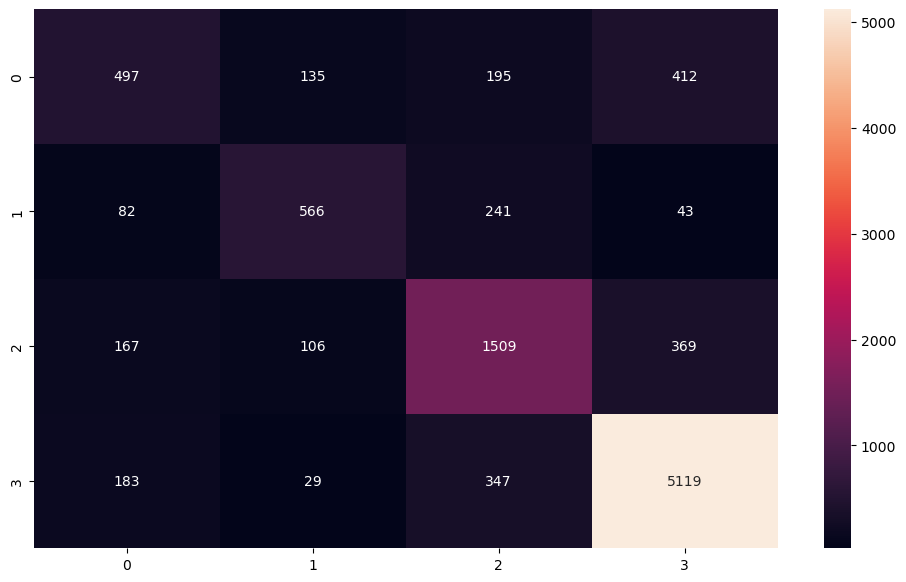

In [45]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')

In [46]:
import pickle
file = open('Logistic_Regression.pkl','wb') ## storing ML model
pickle.dump(pipe,file)

# Demand Forecasting

## Video_Game

In [48]:
db=sql.connect(user='root',password='1234',host='localhost',database='capstone')

In [61]:
vg_tsa=pd.read_sql('select reviewTime,reviewText,title from video_game_sent',con=db)

In [62]:
vg_tsa

,reviewTime,reviewText,title
0,2013-12-06,good wheel use play game becouse when you play...,Logitech PlayStation 3 Driving Force GT Racing...
1,2003-04-01,wow game breath take Cool Visuals gameplay eas...,Kingdom Hearts
2,2015-08-07,love,NBA Live 10 - Playstation 3
3,2015-09-28,arrive fast and way perfect,Razer DeathAdder Chroma - Multi-Color Ergonomi...
4,2017-06-28,second set these headphone purchase my son lov...,KOTION Each G9000 Headset 3.5mm Game Gaming He...
...,...,...,...
49995,2016-09-16,good game,American Truck Simulator: California &ndash; W...
49996,2017-04-17,Stealth may not my cup tea,Assassin's Creed I &amp; II
49997,2014-01-07,great fun and great music been dance with my s...,Just Dance 2014 - Xbox 360
49998,2017-01-20,work ok we not hold very long charge though an...,Xbox 360 Quick Charge Kit


In [56]:
#vg_tsa=pd.read_sql('select Textblob,reviewTime,reviewText,title from video_with_sentiment',con=db)

DatabaseError: Execution failed on sql 'select Textblob,reviewTime,reviewText,title from video_with_sentiment': 1146 (42S02): Table 'capstone.video_with_sentiment' doesn't exist

In [50]:
from textblob import TextBlob

In [51]:
def get_sentiment(text):
    """
    Takes a string of text and returns the polarity and sentiment label using TextBlob library
    """
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    
    if polarity > 0:
        return 'positive'
    elif polarity == 0:
        return 'neutral'
    else:
        return 'negative'

def add_sentiment(df, text_column):
    """
    Takes a dataframe and a column containing text, and adds two new columns for sentiment and polarity
    """
    df['sentiment'] = df[text_column].apply(get_sentiment)
    df['polarity'] = df[text_column].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    return df

In [63]:
add_sentiment(vg_tsa,'reviewText')

,reviewTime,reviewText,title,sentiment,polarity
0,2013-12-06,good wheel use play game becouse when you play...,Logitech PlayStation 3 Driving Force GT Racing...,positive,0.166667
1,2003-04-01,wow game breath take Cool Visuals gameplay eas...,Kingdom Hearts,positive,0.070521
2,2015-08-07,love,NBA Live 10 - Playstation 3,positive,0.500000
3,2015-09-28,arrive fast and way perfect,Razer DeathAdder Chroma - Multi-Color Ergonomi...,positive,0.600000
4,2017-06-28,second set these headphone purchase my son lov...,KOTION Each G9000 Headset 3.5mm Game Gaming He...,positive,0.280303
...,...,...,...,...,...
49995,2016-09-16,good game,American Truck Simulator: California &ndash; W...,positive,0.150000
49996,2017-04-17,Stealth may not my cup tea,Assassin's Creed I &amp; II,neutral,0.000000
49997,2014-01-07,great fun and great music been dance with my s...,Just Dance 2014 - Xbox 360,positive,0.633333
49998,2017-01-20,work ok we not hold very long charge though an...,Xbox 360 Quick Charge Kit,positive,0.123125


In [64]:
vg_tsa['reviewTime']=pd.to_datetime(vg_tsa.reviewTime,infer_datetime_format=True)

In [65]:
vg_tsa.set_index('reviewTime',inplace=True)
vg_tsa.sort_index(inplace=True)

In [66]:
from sklearn.preprocessing import LabelEncoder

In [67]:
le = LabelEncoder()
vg_tsa['sentiment'] =le.fit_transform(vg_tsa['sentiment'])
vg_tsa.head()

,reviewText,title,sentiment,polarity
reviewTime,,,,
1999-11-22,cut chase EQ game unlike no Asheron s call zon...,EverQuest - PC,2,0.064538
1999-11-23,be into combat Fltsims year and good equipment...,Flanker 2.0 - PC,2,0.219444
1999-11-26,expansion pack awesome let you play Army again...,Half-Life Expansion Pack: Opposing Force - PC,2,0.139327
1999-11-27,quake introduce ton new stuff still be true se...,Quake III: Arena,2,0.231061
1999-12-01,agree first minute game rather tough but just ...,Tomb Raider: The Last Revelation - PC,2,0.118592


In [68]:
positive = vg_tsa[['polarity']][vg_tsa.polarity>0]
negative = vg_tsa[['polarity']][vg_tsa.polarity<0]
pos_vg = positive.resample(rule='MS').mean()
neg_vg= negative.resample(rule='MS').mean()

In [69]:
pos_vg.drop(pos_vg[pos_vg['polarity'].isnull()].index,axis=0,inplace=True)

In [70]:
neg_vg.drop(neg_vg[neg_vg['polarity'].isnull()].index,axis=0,inplace=True)

In [71]:
pos_vg=pos_vg[['polarity']]
neg_vg=neg_vg[['polarity']]

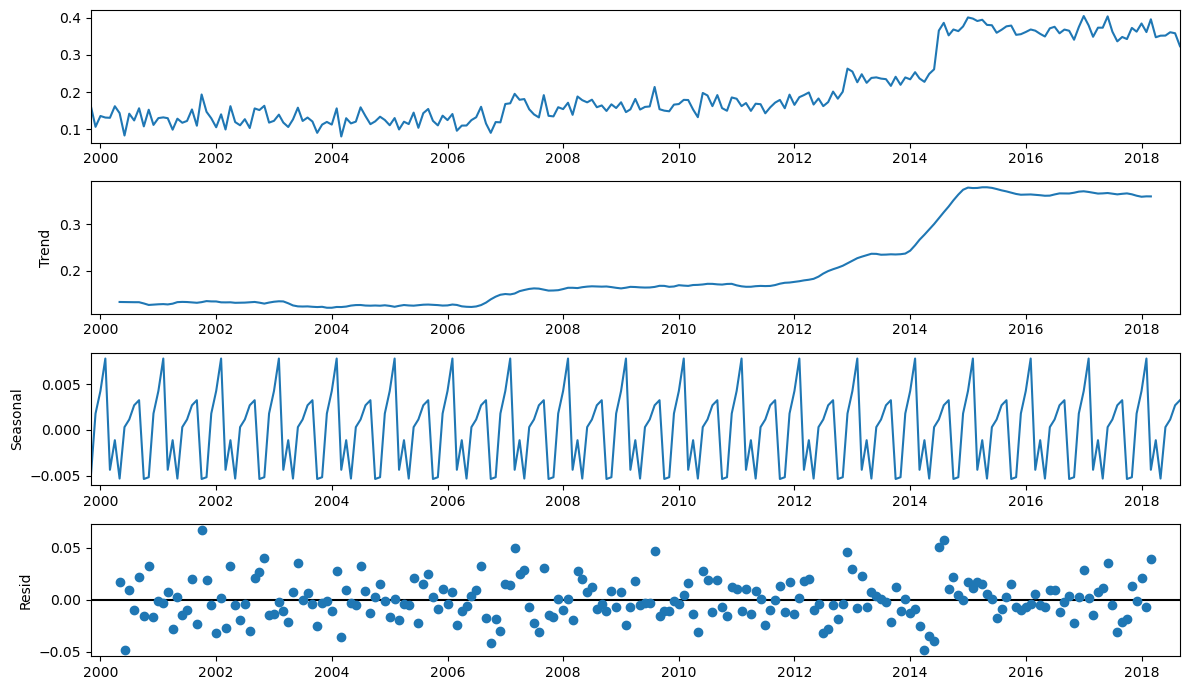

In [72]:
seasonal_decompose(pos_vg,period=12).plot();

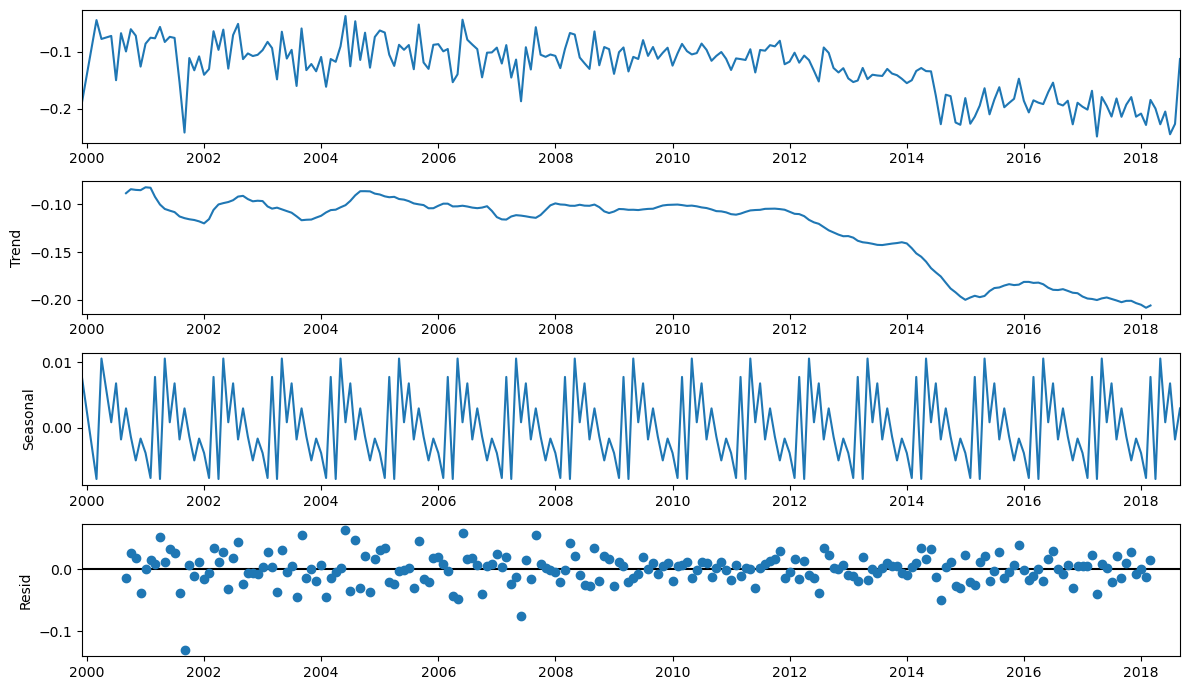

In [73]:
seasonal_decompose(neg_vg,period=12).plot();

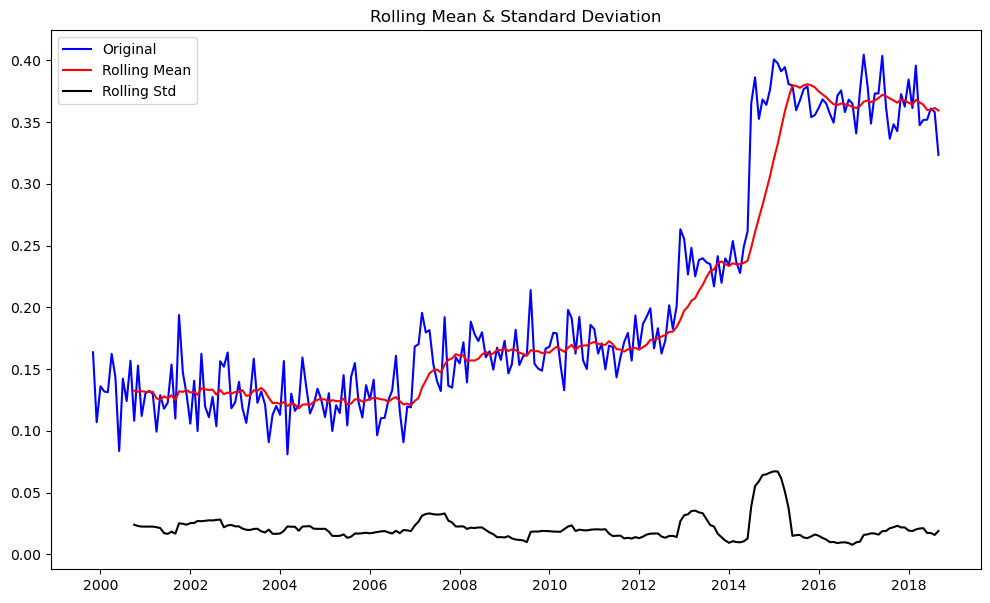

'pvalue=0.9055269445220964. Data is not Stationary. Make the data stationary before model building'

In [74]:
checkstat(pos_vg)

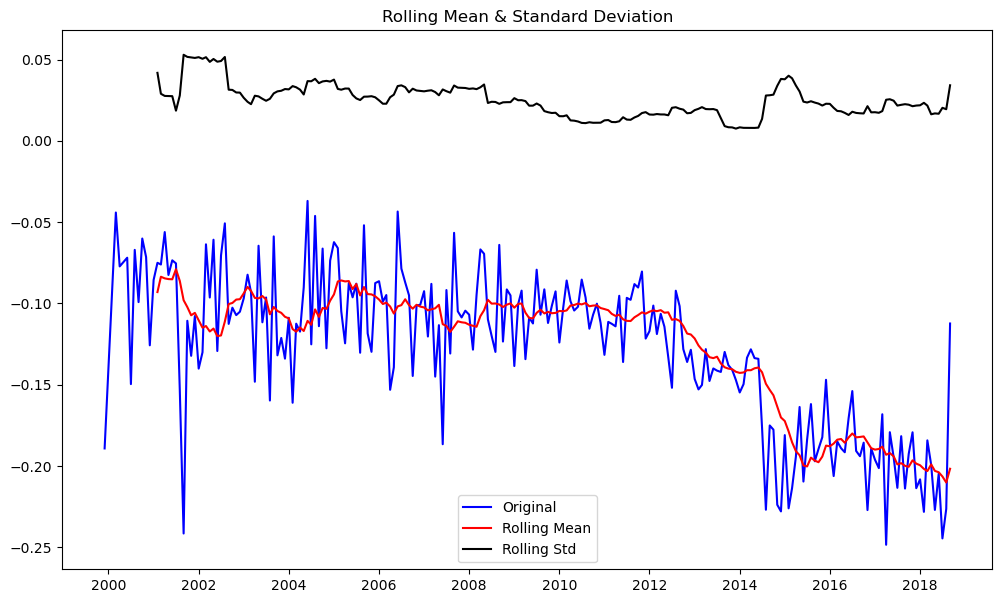

'pvalue=0.9071830073709798. Data is not Stationary. Make the data stationary before model building'

In [75]:
checkstat(neg_vg)

In [76]:
p = range(0,12, 2)
d = 1
q = range(0, 12, 2)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

576


In [78]:
result_vg = optimize_SARIMA(parameters_list, 1, 1, 4,pos_vg)
result_vg

  0%|          | 0/576 [00:00<?, ?it/s]

C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: M

,"(p,q)x(P,Q)",AIC
0,"(0, 2, 0, 1)",-1003.713219
1,"(0, 2, 0, 2)",-1001.778850
2,"(0, 2, 1, 1)",-1001.653056
3,"(2, 2, 0, 1)",-1000.589137
4,"(4, 0, 0, 1)",-1000.438907
...,...,...
139,"(0, 2, 0, 0)",-895.719031
140,"(0, 0, 2, 0)",-885.102620
141,"(0, 0, 1, 0)",-866.737568
142,"(2, 0, 0, 0)",-857.239935


C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


-945.5742500045756
-945.5742500045756
[0.05442088]
Failure to reject H0,Good model


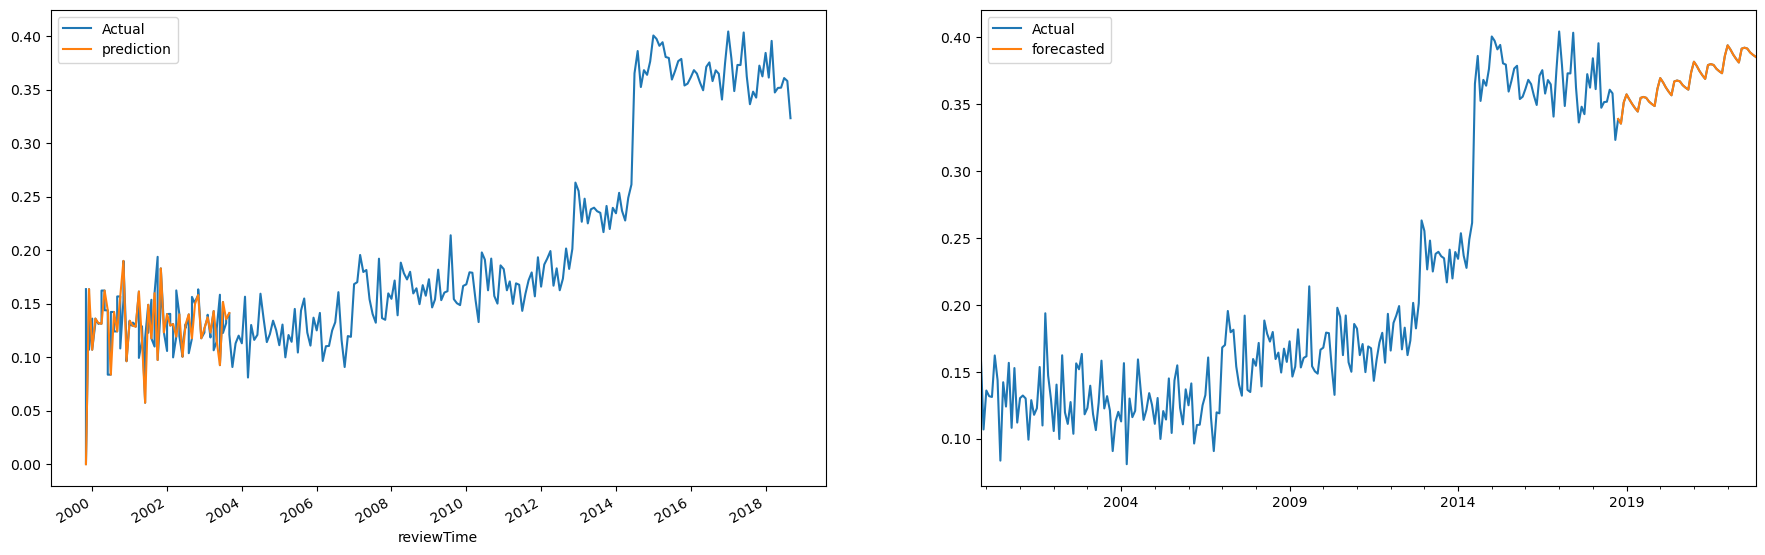

In [82]:
forecasting(pos_vg,4,1,0,0,1,1,0,46)

In [83]:
neg_vg['polarity']=neg_vg['polarity']*-1

In [84]:
neg_vg.shape

(223, 1)

C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Lenovo\anaconda3\li

-819.8446048317414
-819.8446048317414
[0.03093477]
Reject H0 , Bad model


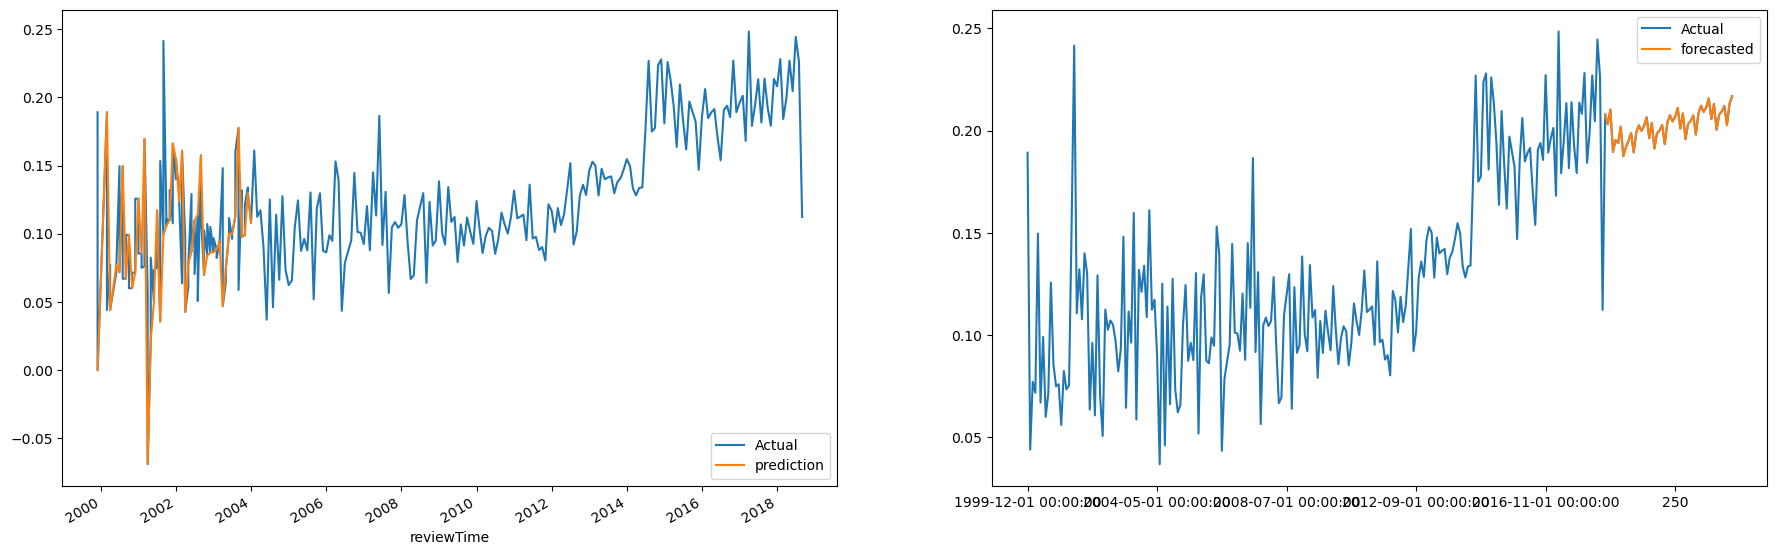

In [85]:
forecasting(neg_vg,4,1,0,0,1,1,0,46)

## Toy and Game

In [ ]:
tag_tsa=pd.read_sql('select reviewTime,reviewText ,sentiment,asin from toy_game',con=db)

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [ ]:
add_sentiment(tag_tsa,'reviewText')

,reviewTime,reviewText,sentiment,asin,polarity
0,2015-01-02,Got it for my 2.5 year old nephew. He didn't l...,positive,B00II4XTS0,0.315000
1,2015-01-02,Kids loved it in the tub and on the tile floor...,positive,B00IQ8MVM8,0.493750
2,2015-01-02,Fun little stroller for quick walks around the...,negative,B006LMZY4S,-0.048333
3,2015-01-02,My son love it,positive,B00A8UT562,0.500000
4,2015-01-02,Can't go wrong with a board game. It's unique...,negative,B000HX1NBA,-0.070000
...,...,...,...,...,...
5242913,2018-10-03,One of the straps snapped after only having th...,negative,B01HHTF4KM,-0.100000
5242914,2018-10-04,NiMH has over twice the charge density of NiCd...,positive,B01HJDFWDK,0.600000
5242915,2018-10-04,A few of the cards were not cut right and also...,positive,B01HH1GMPQ,0.031888
5242916,2018-10-05,These LED rings are super easy to put on and w...,positive,B01HISTOC6,0.441667


In [ ]:
tag_tsa['reviewTime']=pd.to_datetime(tag_tsa.reviewTime,infer_datetime_format=True)

In [ ]:
tag_tsa.set_index('reviewTime',inplace=True)
tag_tsa.sort_index(inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
tag_tsa['sentiment'] =le.fit_transform(tag_tsa['sentiment'])
tag_tsa.head()

,reviewText,sentiment,asin,polarity
reviewTime,,,,
2015-01-02,Got it for my 2.5 year old nephew. He didn't l...,2,B00II4XTS0,0.315000
2015-01-02,Kids loved it in the tub and on the tile floor...,2,B00IQ8MVM8,0.493750
2015-01-02,Fun little stroller for quick walks around the...,0,B006LMZY4S,-0.048333
2015-01-02,My son love it,2,B00A8UT562,0.500000
2015-01-02,Can't go wrong with a board game. It's unique...,0,B000HX1NBA,-0.070000


In [ ]:
positive = tag_tsa[['polarity']][tag_tsa.polarity>0]
negative = tag_tsa[['polarity']][tag_tsa.polarity<0]
pos_tag = positive.resample(rule='MS').mean()
neg_tag= negative.resample(rule='MS').mean()

In [ ]:
pos_tag.drop(pos_tag[pos_tag['polarity'].isnull()].index,axis=0,inplace=True)

In [ ]:
neg_tag.drop(neg_tag[neg_tag['polarity'].isnull()].index,axis=0,inplace=True)

In [ ]:
pos_tag=pos_tag[['polarity']]
neg_tag=neg_tag[['polarity']]

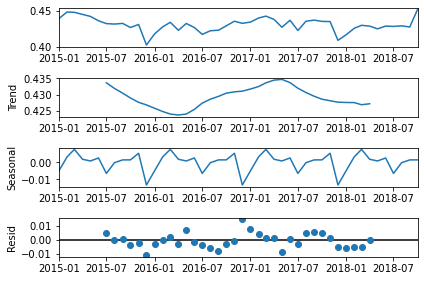

In [ ]:
seasonal_decompose(pos_tag,period=12).plot();

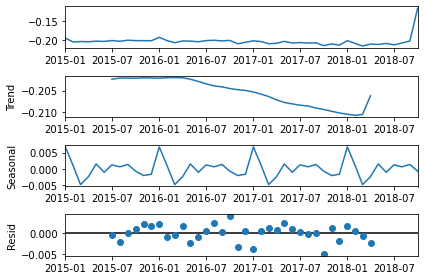

In [ ]:
seasonal_decompose(neg_tag,period=12).plot();

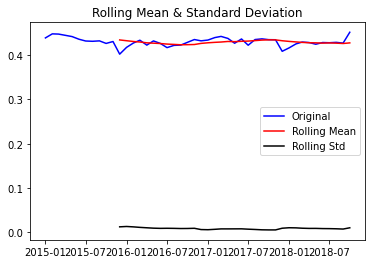

'pvalue=0.00964063092329266. Data is Stationary. Proceed to model building'

In [ ]:
checkstat(pos_tag)

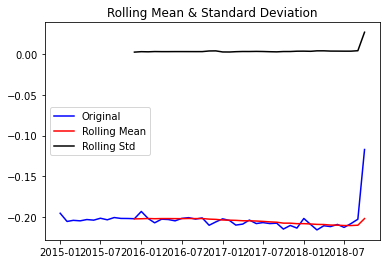

'pvalue=0.4121865200013084. Data is not Stationary. Make the data stationary before model building'

In [ ]:
checkstat(neg_tag)

In [ ]:
p = range(0,12, 2)
d = 1
q = range(0, 12, 2)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

576


In [ ]:
result_vg = optimize_SARIMA(parameters_list, 1, 1, 4,pos_vg)
result_vg

/var/folders/0k/fvxrc6xx287214q6n9hdy0500000gn/T/ipykernel_1450/3985239075.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


  0%|          | 0/576 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py

,"(p,q)x(P,Q)",AIC
0,"(4, 0, 0, 1)",-239.081637
1,"(0, 0, 2, 1)",-239.039707
2,"(0, 0, 0, 1)",-239.027875
3,"(0, 0, 0, 3)",-238.942843
4,"(4, 0, 0, 2)",-237.260091
...,...,...
139,"(2, 10, 0, 0)",274.067419
140,"(4, 10, 0, 0)",278.067163
141,"(6, 10, 0, 0)",282.067476
142,"(10, 8, 0, 0)",286.067987


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.26470D+00    |proj g|=  5.18533D+00

At iterate    5    f= -2.26594D+00    |proj g|=  1.01691D+00

At iterate   10    f= -2.36342D+00    |proj g|=  1.17553D+01

At iterate   15    f= -2.36906D+00    |proj g|=  5.27597D+00

At iterate   20    f= -2.37247D+00    |proj g|=  8.97355D-02

At iterate   25    f= -2.38095D+00    |proj g|=  2.82353D-01

At iterate   30    f= -2.38122D+00    |proj g|=  2.02903D-01
  ys=-6.532E-05  -gs= 1.132E-04 BFGS update SKIPPED

At iterate   35    f= -2.38125D+00    |proj g|=  5.00734D-02

At iterate   40    f= -2.38128D+00    |proj g|=  1.06762D-01

At iterate   45    f= -2.38128D+00    |proj g|=  7.72329D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47    135      2     1     0   6.689D-02  -2.381D+00
  F =  -2.3812823379192327     

ABNORMAL_TERMINATION_IN_LNSRCH                              
-207.07797508856942
-207.07797508856942


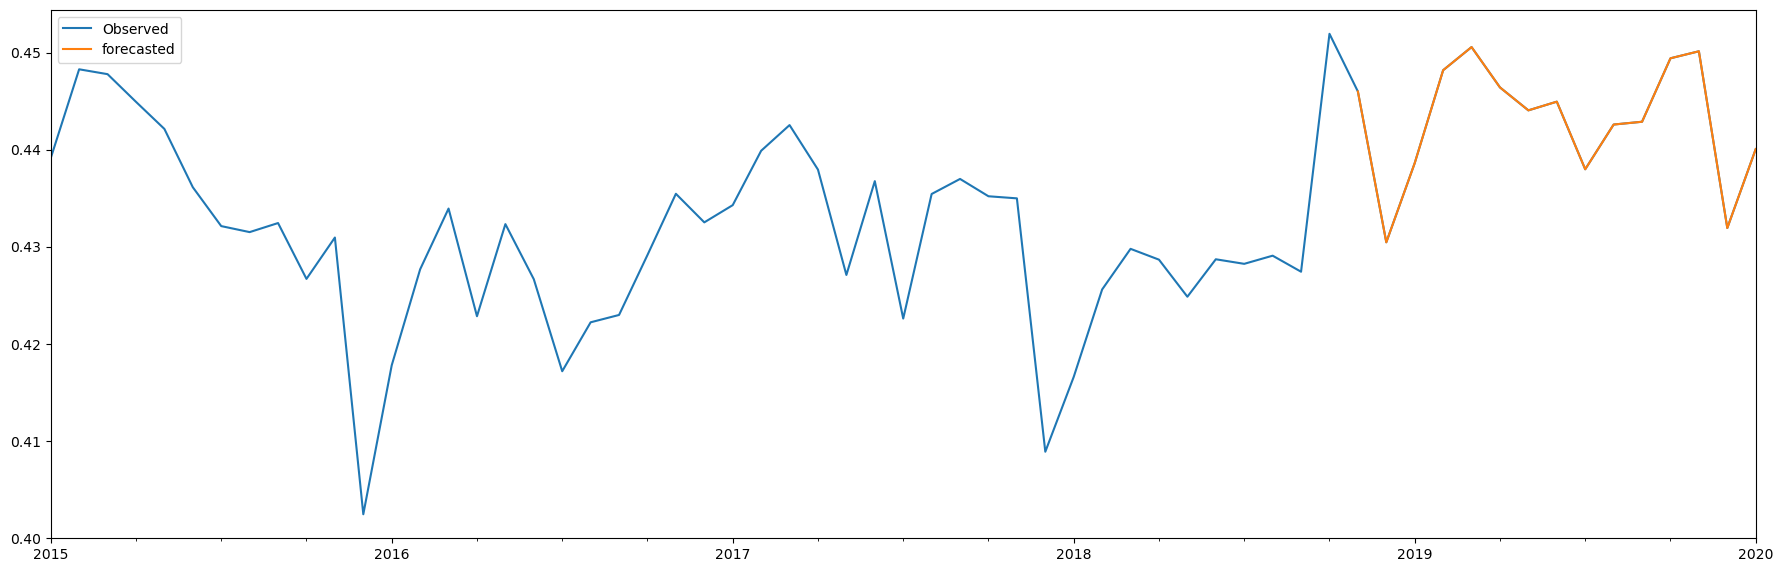

In [ ]:
forecasting(pos_tag,4,1,0,0,1,1,0,46)

In [ ]:
neg_tag['polarity']=neg_tag['polarity']*-1

In [ ]:
neg_vg.shape

(46, 1)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.90189D+00    |proj g|=  4.63352D+00

At iterate    5    f= -1.90383D+00    |proj g|=  5.68166D-01

At iterate   10    f= -1.93045D+00    |proj g|=  1.04196D+01

At iterate   15    f= -1.93830D+00    |proj g|=  3.00602D-02

At iterate   20    f= -1.94015D+00    |proj g|=  1.49746D+00

At iterate   25    f= -1.94221D+00    |proj g|=  1.89282D+00

At iterate   30    f= -1.94313D+00    |proj g|=  1.04827D+00

At iterate   35    f= -1.94445D+00    |proj g|=  8.79851D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39    135      3     0     0   3.315D-02  -1.944D+00
  F =  -1.9444481912854916     

ABNORMAL_TERMINATION_IN_LNSRCH                              
-166.88923359826524
-166.88923359826524


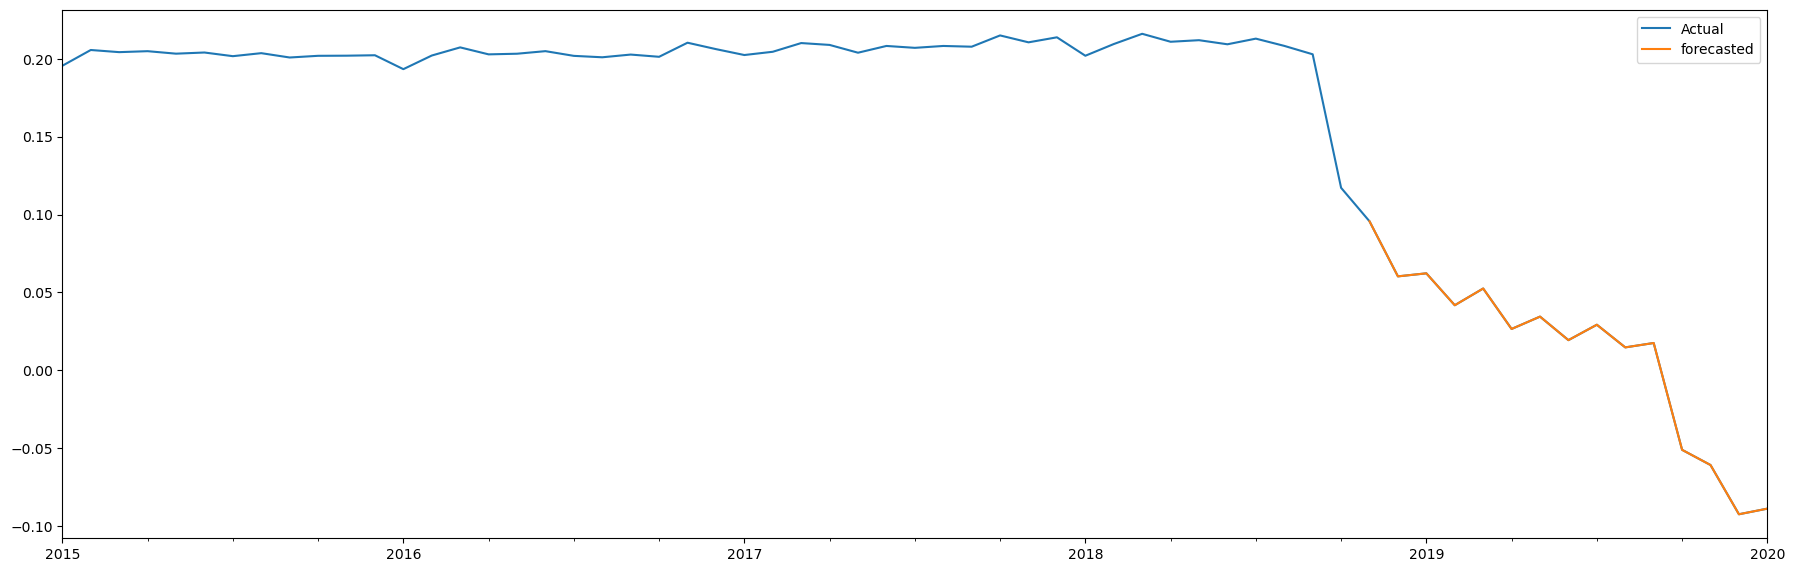

In [ ]:

forecasting(neg_tag,4,1,0,0,1,1,0,46)